Generate a TensorFlow model that predicts values in a sinewave. Based on the code by Pete Warden at https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb

In [2]:
#%tensorflow_version 2.1

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

2023-03-01 20:56:10.367725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

unknown option --versions
usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.20.1
TensorFlow 2.11.0
Keras 2.11.0


In [5]:
# Settings
nsamples = 1000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix

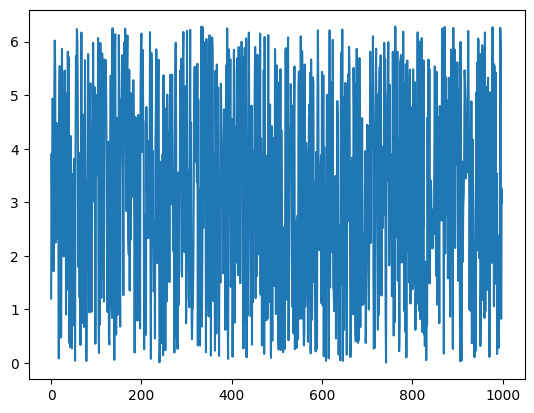

In [6]:
# Generate some random samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

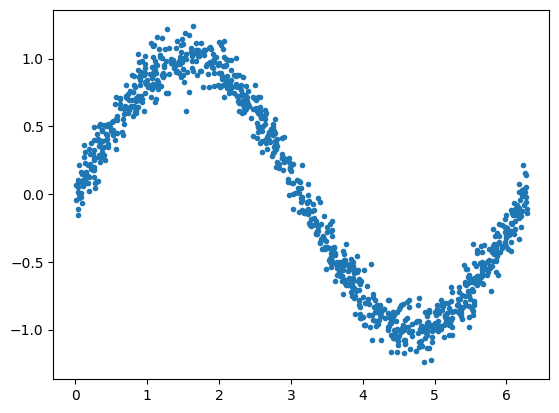

In [7]:
# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

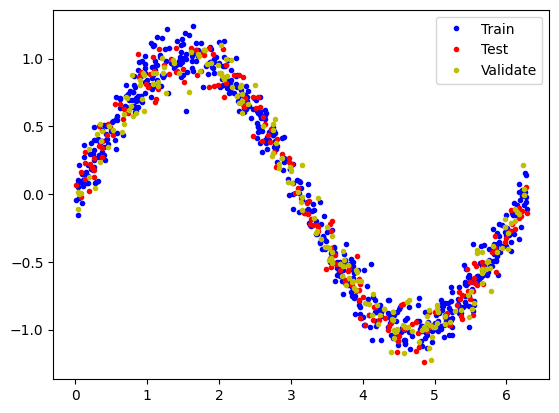

In [8]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [9]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

2023-03-01 20:56:30.618867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# View model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [12]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
6/6 [==============================] - 1s 48ms/step - loss: 0.6294 - mae: 0.6294 - val_loss: 0.5213 - val_mae: 0.5213
Epoch 2/500
6/6 [==============================] - 0s 9ms/step - loss: 0.5503 - mae: 0.5503 - val_loss: 0.5086 - val_mae: 0.5086
Epoch 3/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5348 - mae: 0.5348 - val_loss: 0.5059 - val_mae: 0.5059
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 0.5278 - mae: 0.5278 - val_loss: 0.5041 - val_mae: 0.5041
Epoch 5/500
6/6 [==============================] - 0s 13ms/step - loss: 0.5232 - mae: 0.5232 - val_loss: 0.4991 - val_mae: 0.4991
Epoch 6/500
6/6 [==============================] - 0s 12ms/step - loss: 0.5177 - mae: 0.5177 - val_loss: 0.4928 - val_mae: 0.4928
Epoch 7/500
6/6 [=====

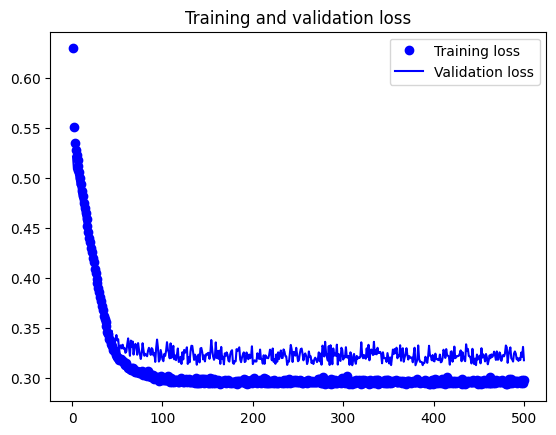

In [13]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 4ms/step


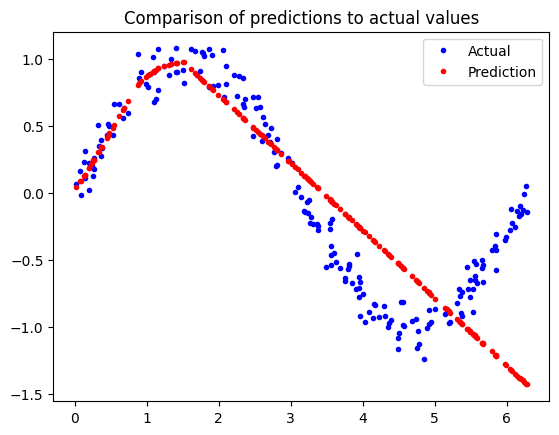

In [14]:
# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [15]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/th/91gccdrx7m975kl4frrh3gnh0000gn/T/tmpyq8s40r9/assets
2023-03-01 20:57:14.729565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-01 20:57:14.730058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-01 20:57:14.745023: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/th/91gccdrx7m975kl4frrh3gnh0000gn/T/tmpyq8s40r9
2023-03-01 20:57:14.748874: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-01 20:57:14.748934: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/th/91gccdrx7m975kl4frrh3gnh0000gn/T/tmpyq8s40r9
2023-03-01 20:57:14.773847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-01 20:57:14.776867: I tensorflow/cc/saved_model/load

INFO:tensorflow:Assets written to: /var/folders/th/91gccdrx7m975kl4frrh3gnh0000gn/T/tmpyq8s40r9/assets


3168

In [16]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [17]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))